In [1]:
import torch
import stable_baselines3
import gym
import numpy
import matplotlib
print('All packages are installed and working.')

All packages are installed and working.


MovieWriter ffmpeg unavailable; using Pillow instead.


(2, 25, 4)


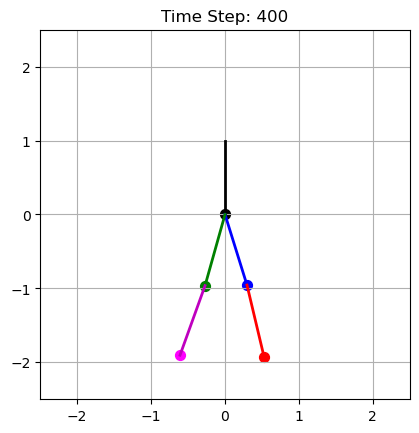

In [2]:
input = np.array([2.5, 1.1, 1.1])
time_pred = gait_generator.generate_gait(input)
animatebiped.animate_biped(time_pred,f"test1.gif")

In [3]:
const = np.load(r"gait reference fft_25_4.88\normalization_constants.npy")
print(const)

[ 96.06238377  97.55270365 275.67054063  99.28346898  96.05309011
  95.02321282 282.21995841  98.68157886]
